In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import arviz as az
import warnings
warnings.filterwarnings("ignore") # , category=FutureWarning
import scipy.stats as st
import scipy.special as ss
from patsy import dmatrix

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### 18.2 Data generation

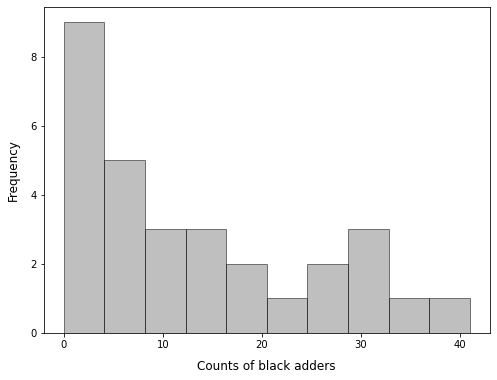

In [2]:
np.random.seed(12345)
n_groups = 3
n_sample = 10
n = n_sample * n_groups
pop = np.repeat(['Jura', 'Black Forest', 'Alps'], n_sample)

wetness_Jura = np.sort(st.uniform.rvs(0, 1, size = n_sample))
wetness_BlackF = np.sort(st.uniform.rvs(0, 1, size = n_sample))
wetness_Alps = np.sort(st.uniform.rvs(0, 1, size = n_sample))
wetness = np.concatenate((wetness_Jura, wetness_BlackF, wetness_Alps))

N = st.randint.rvs(10, 50, size = n)
data_ds = pd.DataFrame({'pop': pd.Series(pop, dtype = 'category'), 'wetness': wetness})
Xmat = dmatrix("~C(pop, Treatment('Jura')) * wetness", data = data_ds, return_type = 'dataframe')
Xmat = Xmat[['Intercept', 
             "C(pop, Treatment('Jura'))[T.Black Forest]",
             "C(pop, Treatment('Jura'))[T.Alps]",
             'wetness',
             "C(pop, Treatment('Jura'))[T.Black Forest]:wetness",
             "C(pop, Treatment('Jura'))[T.Alps]:wetness"]]
beta_vec = [-4, 1, 2, 6, 2, -5]
lin_pred = Xmat.to_numpy() @ beta_vec
exp_p = np.exp(lin_pred) / (1 + np.exp(lin_pred))

Counts = st.binom.rvs(n = N, p = exp_p, size = n)
data = pd.DataFrame({'C': Counts, 
                     'pop': pd.Series(pop, dtype = 'category'),
                     'wetness': wetness,
                     'exp_p': exp_p,
                     'C_N': Counts / N})

plt.figure(figsize = (8, 6))
plt.hist(Counts, color= 'gray', edgecolor='black', alpha = 0.5)
plt.xlabel('Counts of black adders', fontsize = 12, labelpad = 10)
plt.ylabel('Frequency', fontsize = 12, labelpad = 10);

**FIGURE 18.2**

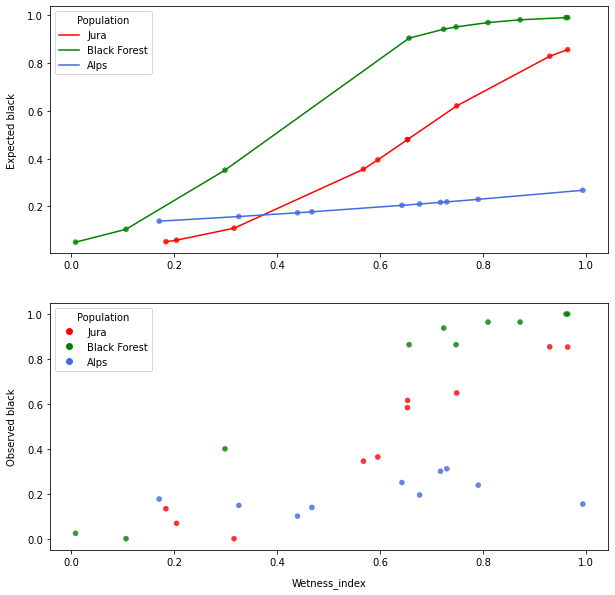

In [3]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10), sharex = False)
colors = {"Jura": 'red', "Black Forest": 'green', "Alps": 'royalblue'}
ax[0].scatter(data['wetness'], data['exp_p'], marker='o', s=25, linewidths=0.5, c=data['pop'].map(colors), alpha = 0.8)
for p, color in zip(['Jura', 'Black Forest', 'Alps'], ['red', 'green', 'royalblue']):
    ax[0].plot(data[data['pop'] == p]['wetness'], data[data['pop'] == p]['exp_p'], c = color, label = p)
ax[0].set_ylabel('Expected black', fontsize = 10, labelpad = 10)
ax[0].legend(title='Population', loc = 'upper left')

#colors = {"Jura": 'red', "Black Forest": 'green', "Alps": 'royalblue'}
ax[1].scatter(data['wetness'], data['C_N'], marker='o', s=25, linewidths=0.5, c=data['pop'].map(colors), alpha = 0.8)
ax[1].set_xlabel('Wetness_index', fontsize = 10, labelpad = 10)
ax[1].set_ylabel('Observed black', fontsize = 10, labelpad = 10)
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax[1].legend(title='Population', handles=handles, loc = 'upper left'); 

### 18.4 Analysis using PyMC3

In [4]:
idx = pd.factorize(pop)[0]

In [5]:
with pm.Model() as model_18_4:
    
    alpha = pm.Normal('alpha', mu=0, tau = 0.01, shape = n_groups)
    beta = pm.Normal('beta', mu=0, tau = 0.01, shape = n_groups) 
    p = pm.Deterministic('p', pm.math.invlogit(alpha[idx] + beta[idx] * wetness))
    Presi = pm.Deterministic('Presi', (Counts - N * p) / pm.math.sqrt(N * p * (1 - p)))
    D = Presi**2
    fit = pm.Deterministic('fit', pm.math.sum(D))
    
    C_pred = pm.Binomial('C_new', n = N, p = p, observed = Counts)
    
    # Derived quantities
    # Recover the effects relative to baseline level (no. 1)
    a_effe2 = pm.Deterministic('a_effect2', alpha[1] - alpha[0])                # Intercept Black Forest vs. Jura
    a_effe3 = pm.Deterministic('a_effect3', alpha[2] - alpha[0])                # Intercept Alps vs. Jura
    b_effe2 = pm.Deterministic('b_effect2', beta[1] - beta[0])                  # Slope Black Forest vs. Jura
    b_effe3 = pm.Deterministic('b_effect3', beta[2] - beta[0])                  # Slope Alps vs. Jura
    
    # Custom tests
    test1 = pm.Deterministic('test1',  beta[2] - beta[1])     # Difference slope Alps -Black Forest

    trace_18_4 = pm.sample(return_inferencedata = True)
    
    C_new = pm.sample_posterior_predictive(trace_18_4)
    data_aux = az.from_pymc3(posterior_predictive = C_new)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


In [6]:
trace_18_4.extend(data_aux)

In [7]:
az.summary(trace_18_4, var_names = ['~Presi', '~p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-3.935,0.509,-4.798,-2.893,0.015,0.011,1217.0,988.0,1.00
alpha[1],-3.475,0.524,-4.457,-2.537,0.016,0.011,1058.0,1179.0,1.00
alpha[2],-2.001,0.536,-2.974,-0.999,0.015,0.011,1278.0,805.0,1.00
beta[0],6.111,0.739,4.583,7.352,0.021,0.015,1238.0,1023.0,1.00
beta[1],8.316,0.892,6.589,9.918,0.027,0.019,1064.0,1109.0,1.01
beta[2],1.153,0.795,-0.454,2.490,0.022,0.016,1308.0,1104.0,1.00
fit,23.956,5.043,17.044,32.543,0.183,0.129,794.0,1120.0,1.00
a_effect2,0.460,0.747,-0.976,1.831,0.022,0.017,1117.0,929.0,1.00
a_effect3,1.934,0.736,0.612,3.360,0.021,0.016,1194.0,1076.0,1.00
b_effect2,2.205,1.187,-0.002,4.449,0.036,0.026,1101.0,1017.0,1.00


In [8]:
p_post = trace_18_4.posterior.stack(samples = {'chain', 'draw'})['p'].values
fit_post = trace_18_4.posterior.stack(samples = {'chain', 'draw'})['fit'].values
Presi = trace_18_4.posterior.stack(samples = {'chain', 'draw'})['Presi'].values
Counts_new = trace_18_4.posterior_predictive.stack(samples = {'chain', 'draw'})['C_new'].values#.mean(axis = 1)

In [9]:
Presi_new = (Counts_new - (N.reshape(-1, 1) * p_post)) / (np.sqrt(N.reshape(-1, 1) * p_post * (1 - p_post)))
D_new = Presi_new**2
fit_new = D_new.mean(axis = 1).sum()
#print(fit_new)
bpvalue = np.mean((Presi_new**2).sum(axis = 0) > fit_post)
print('Bayesian p-value =', bpvalue)

Bayesian p-value = 0.747


**FIGURE 18.3**

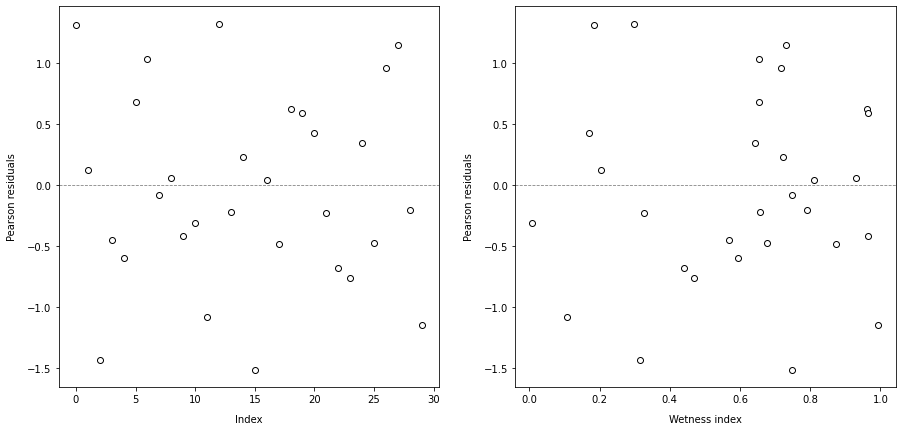

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].scatter(range(len(wetness)), Presi.mean(axis = 1), edgecolor = 'k', facecolor = 'white')
ax[0].axhline(y = 0, xmin = 0, xmax = 18, ls = '--', color = 'k', alpha = 0.5, lw = 0.8)
ax[0].set_xlabel('Index', fontsize = 10, labelpad = 10)
ax[0].set_ylabel('Pearson residuals', fontsize = 10, labelpad = 10)

ax[1].scatter(wetness, Presi.mean(axis = 1), edgecolor = 'k', facecolor = 'white')
ax[1].axhline(y = 0, xmin = 0, xmax = 18, ls = '--', color = 'k', alpha = 0.5, lw = 0.8)
ax[1].set_xlabel('Wetness index', fontsize = 10, labelpad = 10)
ax[1].set_ylabel('Pearson residuals', fontsize = 10, labelpad = 10);

**FIGURE 18.4**

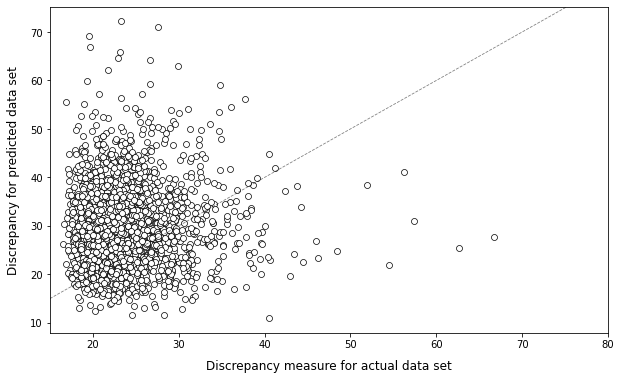

In [12]:
plt.figure(figsize = (10,6))
plt.axline((14, 14), ls = '--', color = 'k', slope=1, alpha = 0.5, lw = 0.8)
plt.scatter(fit_post, (Presi_new**2).sum(axis = 0), edgecolor = 'k', facecolor = 'white', lw = 0.7)
plt.xlim(15, 80)
plt.xlabel('Discrepancy measure for actual data set', fontsize = 12, labelpad = 10)
plt.ylabel('Discrepancy for predicted data set', fontsize = 12, labelpad = 10);